# Detecting Vandalism on Wikipedia

<img src="images/wikipedia.jpg"/>

Wikipedia is a free online encyclopedia that anyone can edit and contribute to. It is available in many languages and is growing all the time. On the English language version of Wikipedia:

    There are currently 4.7 million pages.

    There have been a total over 760 million edits (also called revisions) over its lifetime.

    There are approximately 130,000 edits per day.

One of the consequences of being editable by anyone is that some people vandalize pages. This can take the form of removing content, adding promotional or inappropriate content, or more subtle shifts that change the meaning of the article. With this many articles and edits per day it is difficult for humans to detect all instances of vandalism and revert (undo) them. As a result, Wikipedia uses bots - computer programs that automatically revert edits that look like vandalism. In this assignment we will attempt to develop a vandalism detector that uses machine learning to distinguish between a valid edit and vandalism.

The data for this problem is based on the revision history of the page Language. Wikipedia provides a history for each page that consists of the state of the page at each revision. Rather than manually considering each revision, a script was run that checked whether edits stayed or were reverted. If a change was eventually reverted then that revision is marked as vandalism. This may result in some misclassifications, but the script performs well enough for our needs.

As a result of this preprocessing, some common processing tasks have already been done, including lower-casing and punctuation removal. The columns in the dataset are:

    Vandal = 1 if this edit was vandalism, 0 if not.

    Minor = 1 if the user marked this edit as a "minor edit", 0 if not.

    Loggedin = 1 if the user made this edit while using a Wikipedia account, 0 if they did not.

    Added = The unique words added.

    Removed = The unique words removed.

Notice the repeated use of unique. The data we have available is not the traditional bag of words - rather it is the set of words that were removed or added. For example, if a word was removed multiple times in a revision it will only appear one time in the "Removed" column.

## Problem 1.1 - Bags of Words

Load the data wiki.csv with the option 

    stringsAsFactors=FALSE
    
calling the data frame "wiki". Convert the "Vandal" column to a factor using the command 

    wiki$Vandal = as.factor(wiki$Vandal).

**How many cases of vandalism were detected in the history of this page?**

In [1]:
# Load the dataset
wiki = read.csv("data/wiki.csv", stringsAsFactors=FALSE)

# Convert the column to a factor
wiki$Vandal = as.factor(wiki$Vandal)

In [2]:
head(wiki,3)

,X.1,X,Vandal,Minor,Loggedin,Added,Removed
,<int>,<int>,<fct>,<int>,<int>,<chr>,<chr>
1,1,1,0,1,1,represent psycholinguisticspsycholinguistics orthographyorthography help text all actions through human ethnologue relationships linguistics regarded writing languages to other listing xmlspacepreservelanguages metaverse formal term philology common each including phonologyphonology often ten list humans affiliation see computer are speechpathologyspeech our what for ways dialects please artificial written body be of quite hypothesis found alone refers by about language profanity study programming priorities rosenfelders technologytechnologies makes or first among useful languagephilosophy one sounds use area create phrases mark their genetic basic families complete but sapirwhorfhypothesissapirwhorf with talklanguagetalk population animals this science up vocal can concepts called at and topics locations as numbers have in pathology different develop 4000 things ideas grouped complex animal mathematics fairly literature httpwwwzompistcom philosophy most important meaningful a historicallinguisticsorphilologyhistorical semanticssemantics patterns the oral,
2,2,2,0,1,1,website external links,talklanguagetalk
3,3,3,0,0,1,,regarded as technologytechnologies human first


In [3]:
str(wiki)

'data.frame':	3876 obs. of  7 variables:
 $ X.1     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ X       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Vandal  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Minor   : int  1 1 0 1 1 0 0 0 1 0 ...
 $ Loggedin: int  1 1 1 0 1 1 1 1 1 0 ...
 $ Added   : chr  "  represent psycholinguisticspsycholinguistics orthographyorthography help text all actions through human ethno"| __truncated__ " website external links" " " " afghanistan used iran mostly that farsiis is countries some xmlspacepreservepersian parts tajikestan region" ...
 $ Removed : chr  " " " talklanguagetalk" " regarded as technologytechnologies human first" "  represent psycholinguisticspsycholinguistics orthographyorthography help all actions through ethnologue relat"| __truncated__ ...


In [4]:
# Tabulates the vandalism cases
table(wiki$Vandal)


   0    1 
2061 1815 

Answer: There are 1815 observations with value 1, which denotes vandalism.

### Problem 1.2 - Bags of Words
We will now use the bag of words approach to build a model. We have two columns of textual data, with different meanings. For example, adding rude words has a different meaning to removing rude words. We'll start like we did in class by building a document term matrix from the Added column. The text already is lowercase and stripped of punctuation. So to pre-process the data, just complete the following four steps:

    1) Create the corpus for the Added column, and call it "corpusAdded".

    2) Remove the English-language stopwords.

    3) Stem the words.

    4) Build the DocumentTermMatrix, and call it dtmAdded.

If the code length(stopwords("english")) does not return 174 for you, then please run the line of code in this file, which will store the standard stop words in a variable called sw. When removing stop words, use tm_map(corpusAdded, removeWords, sw) instead of tm_map(corpusAdded, removeWords, stopwords("english")).

**How many terms appear in dtmAdded?**

In [5]:
library(tm)

Loading required package: NLP



In [6]:
# Create the corpus for the Added column, and call it "corpusAdded"
corpusAdded = VCorpus(VectorSource(wiki$Added))

# Remove the English-language stopwords
corpusAdded = tm_map(corpusAdded, removeWords, stopwords("english"))

# Stem the words
corpusAdded = tm_map(corpusAdded, stemDocument)

# Build the DocumentTermMatrix, and call it dtmAdded
dtmAdded = DocumentTermMatrix(corpusAdded)
dtmAdded

<<DocumentTermMatrix (documents: 3876, terms: 6675)>>
Non-/sparse entries: 15368/25856932
Sparsity           : 100%
Maximal term length: 784
Weighting          : term frequency (tf)

Answer: 6675.

### Problem 1.3 - Bags of Words
Filter out sparse terms by keeping only terms that appear in 0.3% or more of the revisions, and call the new matrix sparseAdded.

**How many terms appear in sparseAdded?**

In [7]:
# Filter out the sparse terms
sparseAdded = removeSparseTerms(dtmAdded, 0.997)
sparseAdded

<<DocumentTermMatrix (documents: 3876, terms: 166)>>
Non-/sparse entries: 2681/640735
Sparsity           : 100%
Maximal term length: 28
Weighting          : term frequency (tf)

Answer: 166.

### Problem 1.4 - Bags of Words
Convert sparseAdded to a data frame called wordsAdded, and then prepend all the words with the letter A, by using the command:

    colnames(wordsAdded) = paste("A", colnames(wordsAdded))

Now repeat all of the steps we've done so far (create a corpus, remove stop words, stem the document, create a sparse document term matrix, and convert it to a data frame) to create a Removed bag-of-words dataframe, called wordsRemoved, except this time, prepend all of the words with the letter R:

    colnames(wordsRemoved) = paste("R", colnames(wordsRemoved))

**How many words are in the wordsRemoved data frame?**

In [8]:
#Convert sparseAdded into a dataframe wordAdded
wordsAdded = as.data.frame(as.matrix(sparseAdded))

# Prepend all the words with letter A
colnames(wordsAdded) = paste("A", colnames(wordsAdded))

In [9]:
# Create the corpus for the Added column, and call it "corpusRemoved"
corpusRemoved <- Corpus(VectorSource(wiki$Removed))

In [10]:
# Remove the English-language stopwords
corpusRemoved <- tm_map(corpusRemoved, removeWords, stopwords("english"))

# Stem the words
corpusRemoved <- tm_map(corpusRemoved, stemDocument)

Warning message in tm_map.SimpleCorpus(corpusRemoved, removeWords, stopwords("english")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpusRemoved, stemDocument):
"transformation drops documents"


In [11]:
# Build the DocumentTermMatrix, and call it dtmRemoved
dtmRemoved <- DocumentTermMatrix(corpusRemoved)

sparseRemoved <- removeSparseTerms(dtmRemoved, 0.997)

wordsRemoved <- as.data.frame(as.matrix(sparseRemoved))

colnames(wordsRemoved) = paste("R", colnames(wordsRemoved))

ncol(wordsRemoved)

[1] 162

Answer: 162 words are in wordsRemoved.

### Problem 1.5 - Bags of Words
Combine the two data frames into a data frame called wikiWords with the following line of code:

    wikiWords = cbind(wordsAdded, wordsRemoved)

The cbind function combines two sets of variables for the same observations into one data frame. Then add the Vandal column (HINT: remember how we added the dependent variable back into our data frame in the Twitter lecture). Set the random seed to 123 and then split the data set using sample.split from the "caTools" package to put 70% in the training set.

**What is the accuracy on the test set of a baseline method that always predicts "not vandalism" (the most frequent outcome)?**

In [12]:
# Combine the data frame
wikiWords = cbind(wordsAdded, wordsRemoved)

wikiWords$Vandal = wiki$Vandal

head(wikiWords,3)

,A accord,A actual,A ago,A agre,A analog,A appar,A arbitrari,A believ,A biolog,A biologyanalog,⋯,R homo,R thousand,R icon,R just,R langesnada,R onto,R quothopequot,R quotmeowquot,R xmlspacepreserveotheruses4th,Vandal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Split the dataset into a training and testing set:

In [13]:
library(caTools)

In [14]:
set.seed(123)

# Split
spl = sample.split(wikiWords$Vandal, SplitRatio = 0.7)

wikiTrain = subset(wikiWords, spl==TRUE)
wikiTest = subset(wikiWords, spl==FALSE)

In [15]:
# Tabulates the amount of vandalism in cases
Bl = table(wikiTest$Vandal)
Bl


  0   1 
618 545 

In [16]:
accurBl = max(Bl)/sum(Bl)
paste("Accuracy Baseline:", round(accurBl,digits=4))

[1] "Accuracy Baseline: 0.5314"

### Problem 1.6 - Bags of Words
Build a CART model to predict Vandal, using all of the other variables as independent variables. Use the training set to build the model and the default parameters (don't set values for minbucket or cp).

**What is the accuracy of the model on the test set, using a threshold of 0.5?** (Remember that if you add the argument type="class" when making predictions, the output of predict will automatically use a threshold of 0.5.)

In [17]:
library(rpart)
library(rpart.plot)

In [18]:
# Classification and Regression Trees (CART)
wikiCART = rpart(Vandal ~ ., data=wikiTrain, method="class")

In [19]:
# Make predictions using the CART model
testPredictCART = predict(wikiCART, newdata=wikiTest, type="class")

# Confusion Matrix CART model
cmCA = table(wikiTest$Vandal, testPredictCART)

The rows are labeled with the actual outcome, and the columns are labeled with the predicted outcome.

                      Predict 0       Predict 1
        Actual 0    True Negative   False Positive
        Actual 1    False Negative  True Positive

        cmCA = [1][3]
               [2][4]

In [20]:
# Compute Classification and Regression Trees Accuracy
accurCA = sum(diag(cmCA))/sum(cmCA)
paste("Accuracy CART:", round(accurCA,digits=4))

[1] "Accuracy CART: 0.5443"

### Problem 1.7 - Bags of Words
**Plot the CART tree. How many word stems does the CART model use?**

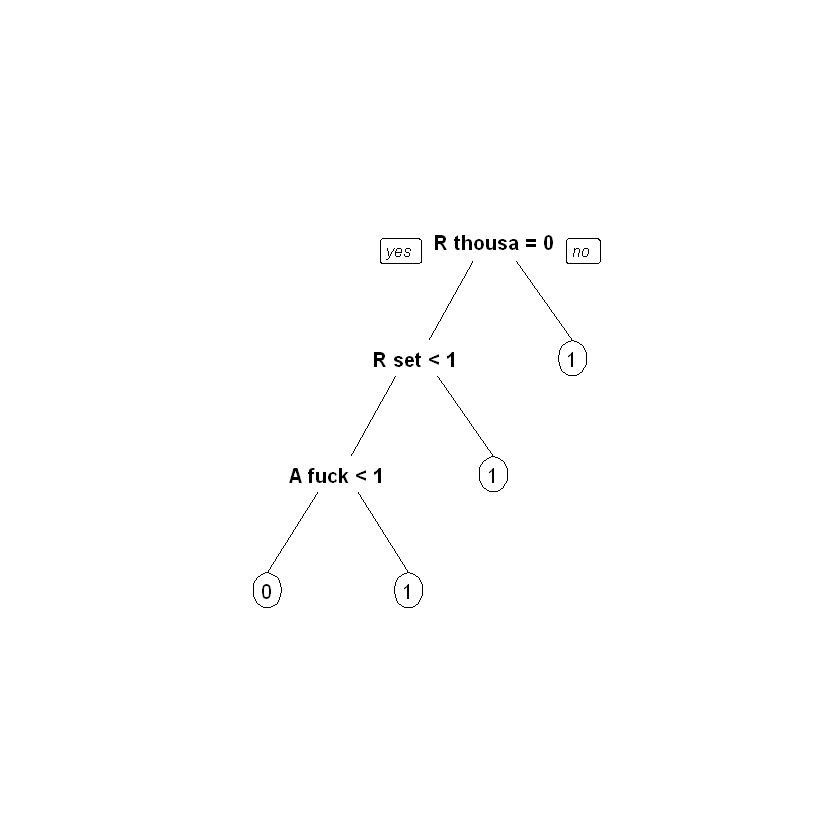

In [21]:
# Plot Tree
prp(wikiCART)

Answer: Thousa, set, fuck (3).

### Problem 1.8 - Bags of Words
**Given the performance of the CART model relative to the baseline, what is the best explanation of these results?**

In [22]:
paste("Accuracy Baseline:", round(accurBl,digits=4))
paste("Accuracy CART:", round(accurCA,digits=4))

[1] "Accuracy Baseline: 0.5314"

[1] "Accuracy CART: 0.5443"

Answer: Few words as a training set, problably model overfit.

### Problem 2.1 - Problem-specific Knowledge
We weren't able to improve on the baseline using the raw textual information. More specifically, the words themselves were not useful. There are other options though, and in this section we will try two techniques - identifying a key class of words, and counting words.

The key class of words we will use are website addresses. "Website addresses" (also known as URLs - Uniform Resource Locators) are comprised of two main parts. An example would be "http://www.google.com". The first part is the protocol, which is usually "http" (HyperText Transfer Protocol). The second part is the address of the site, e.g. "www.google.com". We have stripped all punctuation so links to websites appear in the data as one word, e.g. "httpwwwgooglecom". We hypothesize that given that a lot of vandalism seems to be adding links to promotional or irrelevant websites, the presence of a web address is a sign of vandalism.

We can search for the presence of a web address in the words added by searching for "http" in the Added column. The grepl function returns TRUE if a string is found in another string, e.g.

    grepl("cat","dogs and cats",fixed=TRUE) # TRUE

    grepl("cat","dogs and rats",fixed=TRUE) # FALSE

Create a copy of your dataframe from the previous question:

    wikiWords2 = wikiWords
    
Make a new column in wikiWords2 that is 1 if "http" was in Added:

    wikiWords2$HTTP = ifelse(grepl("http",wiki$Added,fixed=TRUE), 1, 0)

**Based on this new column, how many revisions added a link?**

In [23]:
# Create a copy of your data frame with http added
wikiWords2 = wikiWords

wikiWords2$HTTP = ifelse(grepl("http",wiki$Added,fixed=TRUE), 1, 0)

In [24]:
# Tabulates the amount of words with http
z = table(wikiWords2$HTTP)
z


   0    1 
3659  217 

Answer: 217 revisions added a link.

### Problem 2.2 - Problem-Specific Knowledge
In problem 1.5, you computed a vector called "spl" that identified the observations to put in the training and testing sets. Use that variable (do not recompute it with sample.split) to make new training and testing sets:

    wikiTrain2 = subset(wikiWords2, spl==TRUE)

    wikiTest2 = subset(wikiWords2, spl==FALSE)

Then create a new CART model using this new variable as one of the independent variables.

**What is the new accuracy of the CART model on the test set, using a threshold of 0.5?**

In [25]:
#Subsetting the data into training and test sets

wikiTrain2 = subset(wikiWords2, spl==TRUE)
wikiTest2 = subset(wikiWords2, spl==FALSE)

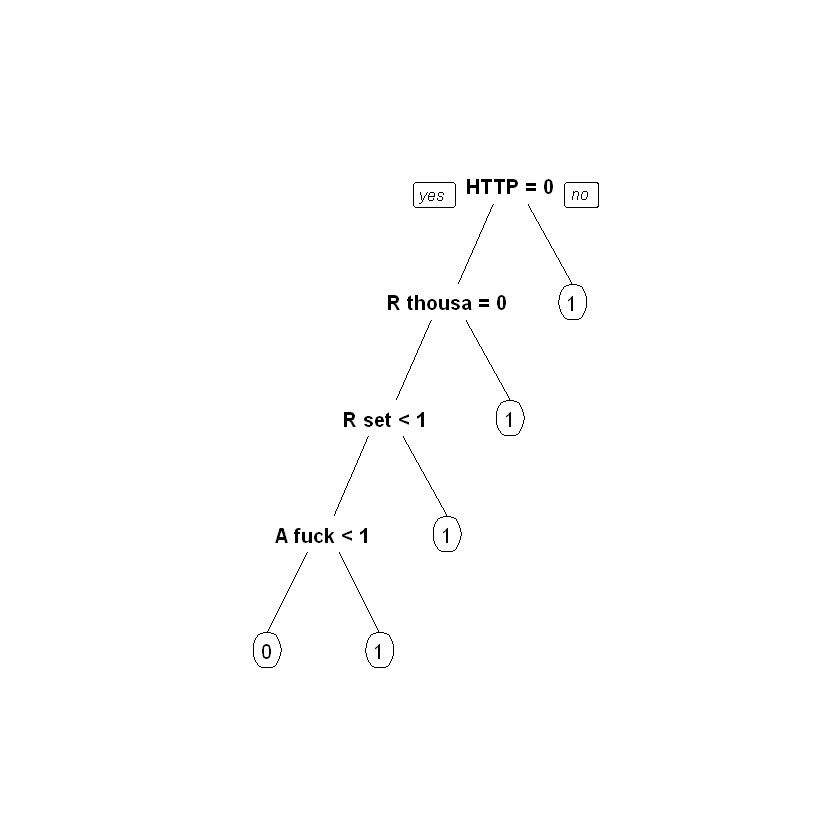

In [26]:
# Create the CART2 model
wikiCART2 = rpart(Vandal ~ ., data=wikiTrain2, method="class")

# Plot CART2
prp(wikiCART2)

In [27]:
# Make Prediction CART2
testPredictCART2 = predict(wikiCART2, newdata=wikiTest2, type="class")

# Confusion Matrix CART2
cmCA2 = table(wikiTest2$Vandal, testPredictCART2)
cmCA2

   testPredictCART2
      0   1
  0 605  13
  1 481  64

In [28]:
# Compute CART2 Accuracy
accurCA2 = sum(diag(cmCA2))/sum(cmCA2)
paste("Accuracy CART2:", round(accurCA2,digits=4))

[1] "Accuracy CART2: 0.5752"

### Problem 2.3 - Problem-Specific Knowledge
Another possibility is that the number of words added and removed is predictive, perhaps more so than the actual words themselves. We already have a word count available in the form of the document-term matrices (DTMs).

Sum the rows of dtmAdded and dtmRemoved and add them as new variables in your data frame wikiWords2 (called NumWordsAdded and NumWordsRemoved) by using the following commands:

    wikiWords2$NumWordsAdded = rowSums(as.matrix(dtmAdded))

    wikiWords2$NumWordsRemoved = rowSums(as.matrix(dtmRemoved))

**What is the average number of words added?**

In [29]:
# Sum the rows and add them as new variables
wikiWords2$NumWordsAdded = rowSums(as.matrix(dtmAdded))
wikiWords2$NumWordsRemoved = rowSums(as.matrix(dtmRemoved))

# Output a summary
summary(wikiWords2$NumWordsAdded)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00    4.05    3.00  259.00 

Answer: 4.05 average number of words are added.

### Problem 2.4 - Problem-Specific Knowledge
In problem 1.5, you computed a vector called "spl" that identified the observations to put in the training and testing sets. Use that variable (do not recompute it with sample.split) to make new training and testing sets with wikiWords2. Create the CART model again (using the training set and the default parameters).

**What is the new accuracy of the CART model on the test set?**

In [30]:
# Split the data into a training set and testing set
wikiTrain3 = subset(wikiWords2, spl==TRUE)
wikiTest3 = subset(wikiWords2, spl==FALSE)

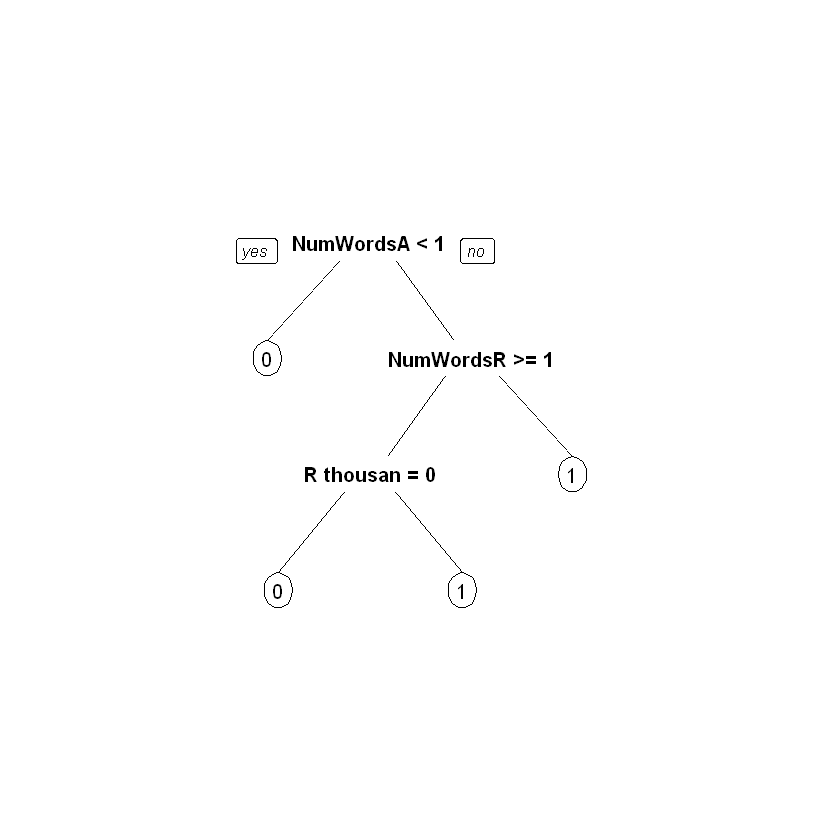

In [31]:
# Implement the CART3 Model
wikiCART3 = rpart(Vandal ~ ., data=wikiTrain3, method="class")

# Plot CART3
prp(wikiCART3)

In [32]:
# Predict using the testing set
testPredictCART3 = predict(wikiCART3, newdata=wikiTest3, type="class")

# Tabulates the testing set vs the predictions
cmCA3 = table(wikiTest3$Vandal, testPredictCART3)
cmCA3

   testPredictCART3
      0   1
  0 514 104
  1 297 248

In [33]:
# Compute CART3 Accuracy
accurCA3 = sum(diag(cmCA3))/sum(cmCA3)
paste("Accuracy CART3:", round(accurCA3,digits=4))

[1] "Accuracy CART3: 0.6552"

### Problem 3.1 - Using Non-Textual Data
We have two pieces of "metadata" (data about data) that we haven't yet used. Make a copy of wikiWords2, and call it wikiWords3:

    wikiWords3 = wikiWords2

Then add the two original variables Minor and Loggedin to this new data frame:

    wikiWords3$Minor = wiki$Minor

    wikiWords3$Loggedin = wiki$Loggedin

In problem 1.5, you computed a vector called "spl" that identified the observations to put in the training and testing sets. Use that variable (do not recompute it with sample.split) to make new training and testing sets with wikiWords3.

**Build a CART model using all the training data. What is the accuracy of the model on the test set?**

In [34]:
# Create a copy of the data and then add the two original variables
wikiWords3 = wikiWords2
wikiWords3$Minor = wiki$Minor
wikiWords3$Loggedin = wiki$Loggedin

In [35]:
# Subset the training and test sets
wikiTrain4 = subset(wikiWords3, spl==TRUE)
wikiTest4 = subset(wikiWords3, spl==FALSE)

In [36]:
# Create the CART4 Model
wikiCART4 = rpart(Vandal ~ ., data=wikiTrain4, method="class")

In [37]:
# Make predictions CART4 Model
testPredictCART4 = predict(wikiCART4, newdata=wikiTest4, type="class")

# Confusion Matrix CART4
cmCA4 = table(wikiTest4$Vandal, testPredictCART4)
cmCA4

   testPredictCART4
      0   1
  0 595  23
  1 304 241

In [38]:
# Compute CART4 Accuracy
accurCA4 = sum(diag(cmCA4))/sum(cmCA4)
paste("Accuracy CART4:", round(accurCA4,digits=4))

[1] "Accuracy CART4: 0.7188"

### Problem 3.2 - Using Non-Textual Data
There is a substantial difference in the accuracy of the model using the meta data. **Is this because we made a more complicated model?**

In [39]:
paste("Accuracy Baseline:", round(accurBl,digits=4))
paste("Accuracy CART:", round(accurCA,digits=4))
paste("Accuracy CART2:", round(accurCA2,digits=4))
paste("Accuracy CART3:", round(accurCA3,digits=4))
paste("Accuracy CART4:", round(accurCA4,digits=4))

[1] "Accuracy Baseline: 0.5314"

[1] "Accuracy CART: 0.5443"

[1] "Accuracy CART2: 0.5752"

[1] "Accuracy CART3: 0.6552"

[1] "Accuracy CART4: 0.7188"

**Plot the CART tree. How many splits are there in the tree?**

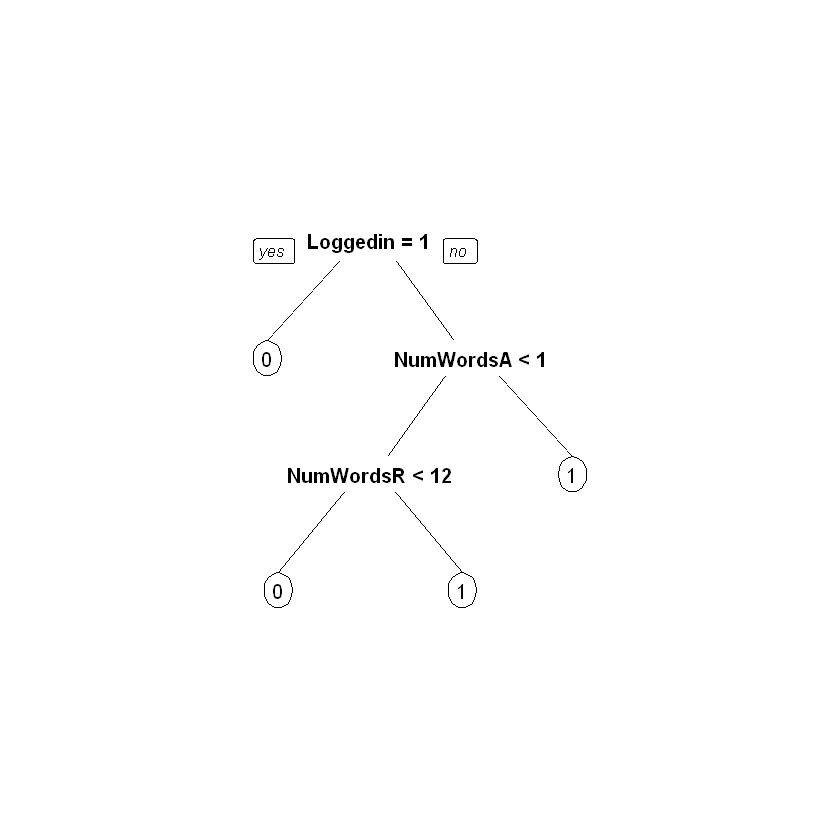

In [40]:
# Plot CART4
prp(wikiCART4)